In [1]:
%matplotlib inline
import texttoideas as TI
import pandas as pd
import numpy as np
from pprint import pprint
from texttoideas.TermDocMatrix import TermDocMatrix, build_from_category_spacy_doc_iter
from texttoideas.RudderChart import *
import mpld3, imp
mpld3.enable_notebook()

In [2]:
speeches = list(TI.iter_party_convention_speech(convention_speech_iter = TI.convention_speech_iter()))

category democrat
# speeches 123
category republican
# speeches 66


In [3]:
pprint([[cat, str(text)[:100].strip()] for cat, text in speeches[:3]])
pprint([[cat, str(text)[:100].strip()] for cat, text in speeches[-3:]])

[[u'democrat',
  'Thank you. Thank you. Thank you. Thank you so much.Thank you.Thank you so much. Thank you. Thank you'],
 [u'democrat',
  'Thank you so much. Tonight, I am so thrilled and so honored and so proud to introduce the love of my'],
 [u'democrat',
  'Thank you. It is a singular honor to be here tonight. Eight years ago in Boston, I introduced you to']]
[[u'republican',
  'To Chairman Priebus and to my fellow Americans who have traveled from every corner of this great cou'],
 [u'republican',
  'Absolutely. Thank you, Mr.Chairman.\nWelcome, everyone, to my home state of Florida, and we are so h'],
 [u'republican',
  "I am thrilled to add Utah's voice in support for Mitt Romney. Let me tell you about the America I kn"]]


In [4]:
imp.reload(TI)
term_doc_mat = TI.build_from_category_spacy_doc_iter(speeches)

In [5]:
df = term_doc_mat.get_term_freq_df()
print df.ix[[x for x in df.index if ' ' not in x]].sum().sum()
print df.ix['romney'].sum()
dfbg = term_doc_mat._get_corpus_joined_to_background()
print '%d' % (dfbg.ix[[x for x in df.index if ' ' not in x]].sum().sum())
print dfbg.ix['romney']
import scipy.stats as stats
#total_corpus = dfbg.ix[[x for x in df.index if ' ' not in x]].sum().sum()
romeny_corpus = dfbg.ix['romney']['background']
table = [[570, 137966 - 570], 
         [dfbg.ix['romney']['background'], 
          dfbg['background'].sum() - dfbg.ix['romney']['background']]]
print table
print stats.fisher_exact(table, alternative='greater')



137966
570
369016983229
corpus           570
background    695398
Name: romney, dtype: float64
[[570, 137396], [695398.0, 588123524789.0]]
(3508.6163308626865, 0.0)


In [6]:
scaled_f_score_df = (term_doc_mat
      .get_scaled_f_score_scores_vs_background(scaler_algo='none')
      .sort_values(by='scaled_f_score', ascending = False))
rudder_df = (term_doc_mat
      .get_rudder_scores_vs_background()
      .sort_values(by='rudder', ascending = True))
postratio_df = (term_doc_mat
      .get_posterior_mean_ratio_scores_vs_background()
      .sort_values(by='Log Posterior Mean Ratio', ascending = False))


In [7]:
fisher_df = term_doc_mat.get_fisher_scores_vs_background()

In [8]:
fisher_df = fisher_df.sort_values(by=['Bonferroni-corrected p-values', 'Odds ratio'], ascending=[True, False])

In [9]:
top_20_fisher = (fisher_df
                 .sort_values(by=['Bonferroni-corrected p-values', 'Odds ratio'], 
                              ascending = [True, False]).index[:20])

## Different methods for comparing 2012 convention speeches to background unigram counts

In [12]:
def get_text(x):
    return x.name + '%s (%d)' % ('*' if x['background'] == 0 else '', x['corpus'])
comparison_to_background_corpora = pd.DataFrame({
        'Top F-Score Terms (Freq)':list(scaled_f_score_df.iloc[:20].apply(get_text, axis=1)),
        'Top Rudder Terms (Freq)':list(rudder_df.iloc[:20].apply(get_text, axis=1)),
        'Top Fisher Terms (Freq)':list(fisher_df.iloc[:20].apply(get_text, axis=1))
    })
comparison_to_background_corpora[:12]


,Top F-Score Terms (Freq),Top Fisher Terms (Freq),Top Rudder Terms (Freq)
0,obama (702),obama (702),obamacare* (33)
1,romney (570),barack (248),romneys* (8)
2,barack (248),romney (570),yohana* (3)
3,mitt (501),mitt (501),nevadan* (2)
4,obamacare* (33),republican (228),solyndra* (2)
5,biden (46),president (1049),breth* (2)
6,romneys* (8),thank (366),outeducate* (2)
7,grandchild (34),america (689),vouchercare* (2)
8,steelworker (6),u (529),bendiga* (2)
9,kansa (6),american (653),gjelsvik* (2)


In [50]:
df = term_doc_mat.get_term_freq_df()
df['rudder dem'] = term_doc_mat.get_rudder_scores('democrat')
df['rudder rep'] = term_doc_mat.get_rudder_scores('republican')
df['logregl2 dem'], acc, bl = term_doc_mat.get_logistic_regression_coefs_l2('democrat')
df['logregl2 rep'], acc, bl = term_doc_mat.get_logistic_regression_coefs_l2('republican')
df['logregl1 dem'], acc, bl = term_doc_mat.get_logistic_regression_coefs_l1('democrat')
#df['logregl1 rep'], acc, bl = term_doc_mat.get_logistic_regression_coefs_l1('republican')


In [77]:
df['oddratio'], df['p'] = term_doc_mat.get_fisher_scores('democrat')


In [79]:
df['fscore-pctl dem'] = np.array(term_doc_mat.get_scaled_f_scores(
        'democrat', scaler_algo='percentile'))
df['fscore-none dem'] = np.array(term_doc_mat.get_scaled_f_scores(
        'democrat', scaler_algo='none'))

In [64]:
df['fscore-none dem'].ix[['boy','affordable', 'ann', 'olympics', 'the']]

term
boy           0.000092
affordable    0.000406
ann           0.000013
olympics      0.000013
the           0.042874
Name: fscore-none dem, dtype: float64

In [98]:
print 'Democratic Associations'
def get_text(x):
    return '%s (%d:%d)' % (x.name, x['democrat freq'], 
                                        x['republican freq'])
all_df=pd.DataFrame({
        'Rudder': list(df.sort_values(by='rudder dem')
                              .apply(get_text, axis=1)[:20]),
        'Fisher': list(df.sort_values(by='p')
                              .apply(get_text, axis=1)[:20]),
        'F-Score-Percentile': list(df.sort_values(by='fscore-pctl dem', ascending=False)
                               .apply(get_text, axis=1)[:20]), 
        #'F-Score': list(df.sort_values(by='fscore-none dem', ascending=False)
         #                      .apply(get_text, axis=1)[:20]), 
        'LogReg-L2': list(df.sort_values(by='logregl2 dem', ascending=False)
                               .apply(get_text, axis=1)[:20]),
        'LogReg-L1': list(df.sort_values(by='logregl1 dem', ascending=False)
                               .apply(get_text, axis=1)[:20]) 
})


Democratic Associations


In [81]:
pd.DataFrame({
        
        'F-Score-Percentile': list(df.sort_values(by='fscore-pctl dem', ascending=False)
                               .apply(get_text, axis=1)[:20]), 
        'F-Score': list(df.sort_values(by='fscore-none dem', ascending=False)
                               .apply(get_text, axis=1)[:20]), 
})


,F-Score,F-Score-Percentile
0,the (3399:2531),fight for (108:7)
1,and (2707:2232),auto (37:0)
2,to (2337:1664),fair (47:3)
3,be (2326:1972),insurance company (28:0)
4,a (1596:1346),america forward (28:0)
5,of (1565:1372),middle class (149:18)
6,that (1400:1051),president barack (47:4)
7,we (1318:1146),auto industry (24:0)
8,in (1287:983),pell grant (23:0)
9,i (1098:850),pell (23:0)


In [125]:
all_df

,F-Score-Percentile,Fisher,LogReg-L1,LogReg-L2,Rudder
0,fight for (108:7),president obama (351:78),president obama (351:78),obama (537:165),auto (37:0)
1,auto (37:0),obama (537:165),barack (202:46),president obama (351:78),insurance company (28:0)
2,fair (47:3),president (746:303),cut (118:24),president (746:303),america forward (28:0)
3,insurance company (28:0),middle class (149:18),worker (54:9),for (1020:542),auto industry (24:0)
4,america forward (28:0),fight for (108:7),all of (61:23),barack (202:46),pell (23:0)
5,middle class (149:18),class (162:25),charlotte (28:3),forward (105:16),wealthy (23:0)
6,president barack (47:4),middle (164:27),today 's (12:3),fight (165:31),pell grant (23:0)
7,auto industry (24:0),barack (202:46),so that (33:9),fight for (108:7),last week (22:0)
8,pell grant (23:0),fight (165:31),forward (105:16),class (162:25),the wealthy (21:0)
9,pell (23:0),forward (105:16),that ' (236:91),barack obama (164:45),romney say (21:0)


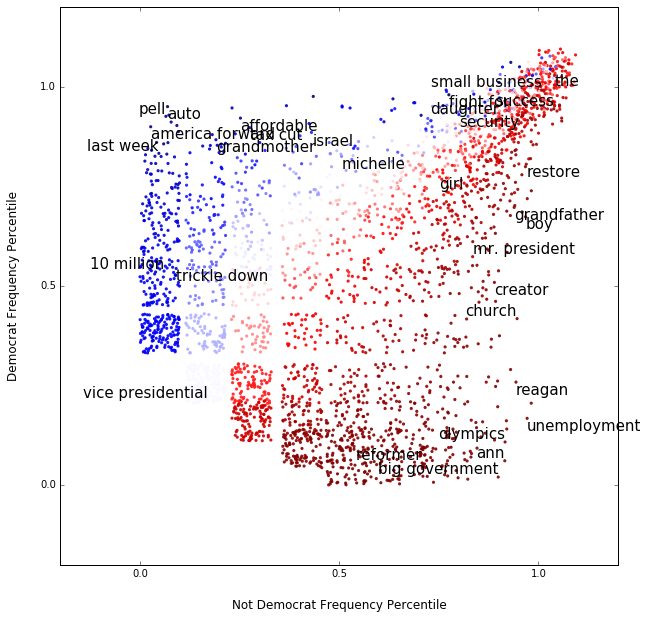

In [89]:
import imp
import texttoideas
imp.reload(texttoideas.RudderChart)
rudder_chart = texttoideas.RudderChart.RudderChart(term_doc_mat, 
                                                   jitter=0.1)
plt.rcParams['figure.figsize'] = (10, 10)
drawn_df, fig_html = rudder_chart.draw('democrat', 
                                       scores = np.array(term_doc_mat.get_scaled_f_scores('democrat', scaler_algo='percentile')),
                                       num_top_words_to_annotate = 0,
                                       words_to_annotate=['the', 'america forward', 'auto', 
                                                          'pell', 'affordable', 'fight for',
                                                         'israel', 'tax cut', 'security', 
                                                         'michelle', 'last week',
                                                          'big government',
                                                          'olympics', 'ann',
                                                          'small business',
                                                          'success',
                                                          'boy',
                                                          'girl',
                                                          'restore',
                                                          'grandfather',
                                                          'grandmother',
                                                          'daughter',
                                                          'god bless'
                                                         'ideology',
                                                         'mr. president',
                                                         'restore',
                                                         'reagan',
                                                          'church',
                                                          'trickle down',
                                                          'rosevelt',
                                                          '10 million',
                                                          'vice presidential',
                                                         'creator',
                                                         'reformer',
                                                         'unemployment'])
open('fig.html','w').write(fig_html)

In [108]:
term_doc_mat._category_idx_store = texttoideas.IndexStore()
term_doc_mat._category_idx_store.getidx('democrat')
term_doc_mat._category_idx_store.getidx('republican')
print df.columns

Index([     u'democrat freq',    u'republican freq',         u'rudder dem',
               u'rudder rep',       u'logregl2 dem',       u'logregl2 rep',
             u'logregl1 dem', u'fscore-normcdf dem',    u'fscore-none dem',
                 u'oddratio',                  u'p',    u'fscore-pctl dem'],
      dtype='object')


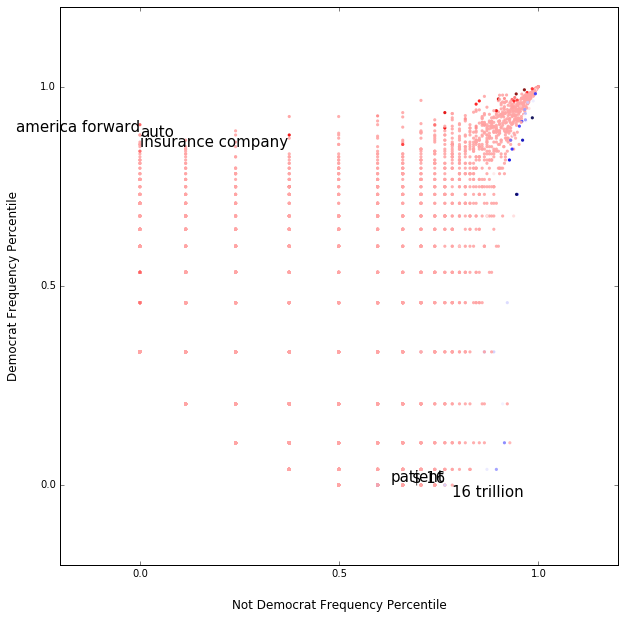

In [124]:
rudder_chart = texttoideas.RudderChart.RudderChart(term_doc_mat, 
                                                   jitter=0)
drawn_df, fig_html = rudder_chart.draw('democrat', 
                                       scores = -1*df['logregl1 dem'],
                                       num_top_words_to_annotate = 3)
